In [58]:
# %pip install yfinance
# %pip install scipy
# %pip install matplotlib
# %pip install pyfolio
# %pip uninstall pyfolio
# %pip install git+https://github.com/quantopian/pyfolio
# %pip install panda

In [1]:
# Ignore printing all warnings
import warnings
warnings.filterwarnings('ignore')

# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pyfolio as pf
import datetime as dt
import pandas_datareader.data as web
import os
# import warnings

# print all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy.stats import rankdata

In [2]:
ticker_list = ['AAPL', 'ADBE', 'AMZN', 'CRM', 'CRWD', 'ETSY', 'META', 'GOOGL', 'MA', 'MSFT', 'NOW', 'NVDA', 'PYPL', 'QCOM', 'SE', 'SHOP', 'SQ', 'V']
perc_ch_lb_list = [60, 120, 180, 250]
vol_lb = 20
perc_ch_up_thres = 0.75
perc_ch_low_thres = 0.25
rebalance_unit = 'Day'
rebalance_freq = 1
rebalance_shift = 0
start_date = '2007-01-01'
end_date = '2022-06-10'

In [3]:
adj_close_price = yf.download(ticker_list,start = pd.to_datetime(start_date) + pd.DateOffset(years= -2),end = pd.to_datetime(end_date) + pd.DateOffset(days= 1) )['Adj Close']

[*********************100%***********************]  18 of 18 completed


In [4]:
df = adj_close_price.copy()
df['Year'], df['Month'], df['Week'] = df.index.year, df.index.month, df.index.week
df['Monthly_Rb'] = df.Month != df.Month.shift(-1)
df['Weekly_Rb'] = df.Week != df.Week.shift(-1)
df['Daily_Rb'] = True
df['RebalanceUnit'] = df.Monthly_Rb if rebalance_unit == 'Month' else df.Weekly_Rb if rebalance_unit == 'Week' else df.Daily_Rb
df.RebalanceUnit = df.RebalanceUnit.shift(rebalance_shift).fillna(False) 
df.RebalanceUnit[0] = True
df['NoPeriod'] = df.RebalanceUnit.shift(1).cumsum()
df.NoPeriod[0] = 0
df['NoData'] = np.arange(len(df)) + 1
df['Rebalance'] = np.where((df.RebalanceUnit == True) & (df.NoPeriod.mod(rebalance_freq) == 0), True, False)

In [5]:
dailyret = adj_close_price/adj_close_price.shift(1) - 1

In [6]:
def scores(acp_p, lb_p, l_th_p, u_th_p):

    lowerPerc = acp_p.rolling(lb_p).quantile(l_th_p).to_numpy()
    upperPerc = acp_p.rolling(lb_p).quantile(u_th_p).to_numpy()
    prices = acp_p.to_numpy()
    no_rows, no_cols = acp_p.shape
    score = np.zeros((no_rows, no_cols))
    for i in range(1, no_rows):
        for j in range(no_cols):
            if prices[i,j] > upperPerc[i,j]:
                score[i,j] = 1
            elif prices[i,j] < lowerPerc[i,j]:
                score[i,j] = -1
            else:
                score[i,j] = score[i-1,j]
    score_df = pd.DataFrame(score, index = acp_p.index, columns = acp_p.columns) 
    return score_df

In [7]:
scores1 = scores(adj_close_price, perc_ch_lb_list[0], perc_ch_low_thres, perc_ch_up_thres)
scores2 = scores(adj_close_price, perc_ch_lb_list[1], perc_ch_low_thres, perc_ch_up_thres)
scores3 = scores(adj_close_price, perc_ch_lb_list[2], perc_ch_low_thres, perc_ch_up_thres)
scores4 = scores(adj_close_price, perc_ch_lb_list[3], perc_ch_low_thres, perc_ch_up_thres)
avgscores = (scores1 + scores2 + scores3 + scores4)/4
volatility = dailyret.rolling(vol_lb).std(perc_ch_low_thres)
rel_score_vol = avgscores / volatility
abs_score_vol = rel_score_vol.abs()
sum_abs_score_vol = abs_score_vol.sum(axis = 1)
weights = (rel_score_vol.divide(sum_abs_score_vol, axis = 0)).where(rel_score_vol > 0, 0)
cash_weight = 1 - weights.sum(axis = 1)


In [8]:
def positions_pv(acp_p, rebalance_p, weights_p, cash_weight_p, start_date_p):
    adjclose = acp_p.fillna(1).to_numpy()
    rebalanceday = rebalance_p.to_numpy()
    weights = weights_p.fillna(0).to_numpy()
    cash_weight = cash_weight_p.to_numpy()
    no_rows, no_cols = acp_p.shape

    positions = np.zeros((no_rows, no_cols))
    pv = np.ones((no_rows,1))
    cash = np.ones((no_rows,1))
    start_ind = np.argmax(acp_p.index >= start_date_p)
    for i in range(start_ind, no_rows):
        pv[i] = 0
        for j in range(no_cols):
            if rebalanceday[i-1] == True:
                positions[i,j] = pv[i-1] * weights[i-1,j] / adjclose[i-1,j]                
            else:
                positions[i,j] = positions[i-1,j]
            pv[i] += positions[i,j] * adjclose[i,j]
        if rebalanceday[i-1] == True:
            cash[i] = pv[i-1] * cash_weight[i-1]
        else:
            cash[i] = cash[i-1]
        pv[i] += cash[i] 
    
    positions_df = pd.DataFrame(positions, index = acp_p.index, columns = acp_p.columns)
    positions_df_sel = positions_df.iloc[start_ind-1:no_rows,:]
    pv_df =  pd.DataFrame(pv, index = acp_p.index)
    pv_df_sel = pv_df.iloc[start_ind-1:no_rows,0]
    cash_df =  pd.DataFrame(cash, index = acp_p.index)
    cash_df_sel = cash_df.iloc[start_ind-1:no_rows,0]
    return positions_df_sel, cash_df_sel, pv_df_sel

In [9]:
def positions_pv_ew(acp_p, rebalance_p, start_date_p):
    adjclose = acp_p.fillna(0).to_numpy()
    rebalanceday = rebalance_p.to_numpy()
    no_rows, no_cols = acp_p.shape
    no_ava_etfs = (acp_p > 0).sum(1)

    positions = np.zeros((no_rows, no_cols))
    pv = np.ones((no_rows,1))
    cash = np.ones((no_rows,1))
    start_ind = np.argmax(acp_p.index >= start_date_p)
    for i in range(start_ind, no_rows):
        pv[i] = 0
        for j in range(no_cols):
            if rebalanceday[i-1] == True:
                positions[i,j] = pv[i-1] * (1 / no_ava_etfs[i-1]) / adjclose[i-1,j] if adjclose[i-1, j] > 0 else 0                
            else:
                positions[i,j] = positions[i-1,j]
            pv[i] += positions[i,j] * adjclose[i,j]
        if rebalanceday[i-1] == True:
            cash[i] = 0
        else:
            cash[i] = 0
        pv[i] += cash[i] 
    
    positions_df = pd.DataFrame(positions, index = acp_p.index, columns = acp_p.columns)
    positions_df_sel = positions_df.iloc[start_ind-1:no_rows,:]
    pv_df =  pd.DataFrame(pv, index = acp_p.index)
    pv_df_sel = pv_df.iloc[start_ind-1:no_rows,0]
    cash_df =  pd.DataFrame(cash, index = acp_p.index)
    cash_df_sel = cash_df.iloc[start_ind-1:no_rows,0]
    return positions_df_sel, cash_df_sel, pv_df_sel

Start date,2006-12-29
End date,2022-06-10
Total months,185
,Backtest
Annual return,21.258%
Cumulative returns,1858.209%
Annual volatility,17.23%
Sharpe ratio,1.21
Calmar ratio,0.89
Stability,0.97
Max drawdown,-23.901%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.90,2020-02-19,2020-03-20,2020-06-17,86
1,20.23,2007-11-06,2009-05-13,2009-09-09,482
2,19.95,2018-10-01,2018-12-24,2019-07-11,204
3,17.06,2021-11-19,2022-05-09,NaT,NaN
4,13.29,2010-01-05,2010-02-04,2010-04-22,78


Stress Events,mean,min,max
Lehman,-0.22%,-1.93%,1.91%
US downgrade/European Debt Crisis,-0.19%,-4.27%,3.48%
Fukushima,0.08%,-2.41%,2.32%
EZB IR Event,-0.01%,-1.59%,1.70%
Aug07,-0.06%,-3.15%,1.65%
Mar08,0.08%,-0.81%,1.10%
Sept08,-0.35%,-1.93%,0.90%
2009Q1,0.00%,-0.06%,0.04%
2009Q2,0.12%,-3.82%,3.60%
Flash Crash,-0.60%,-2.58%,3.96%


Top 10 long positions of all time,max
AMZN,54.38%
QCOM,44.76%
MSFT,41.05%
V,33.15%
AAPL,31.87%
GOOGL,31.36%
NVDA,29.10%
MA,27.14%
ADBE,25.77%
CRM,22.04%


Top 10 short positions of all time,max


Top 10 positions of all time,max
AMZN,54.38%
QCOM,44.76%
MSFT,41.05%
V,33.15%
AAPL,31.87%
GOOGL,31.36%
NVDA,29.10%
MA,27.14%
ADBE,25.77%
CRM,22.04%


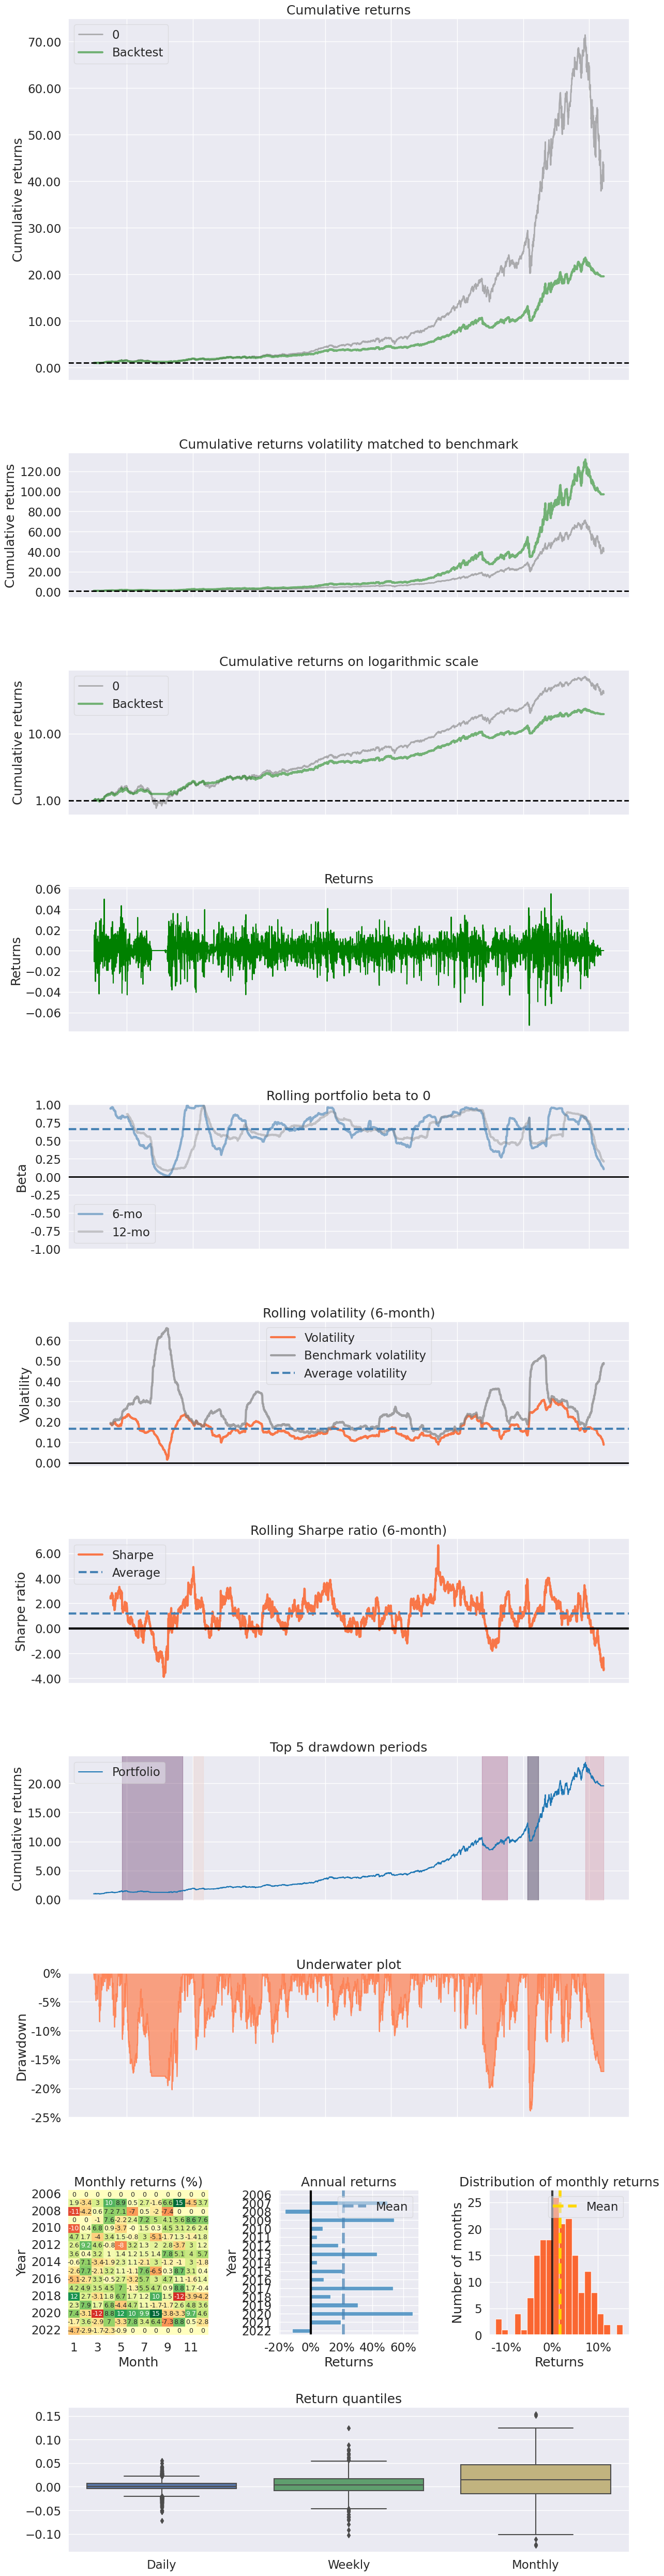

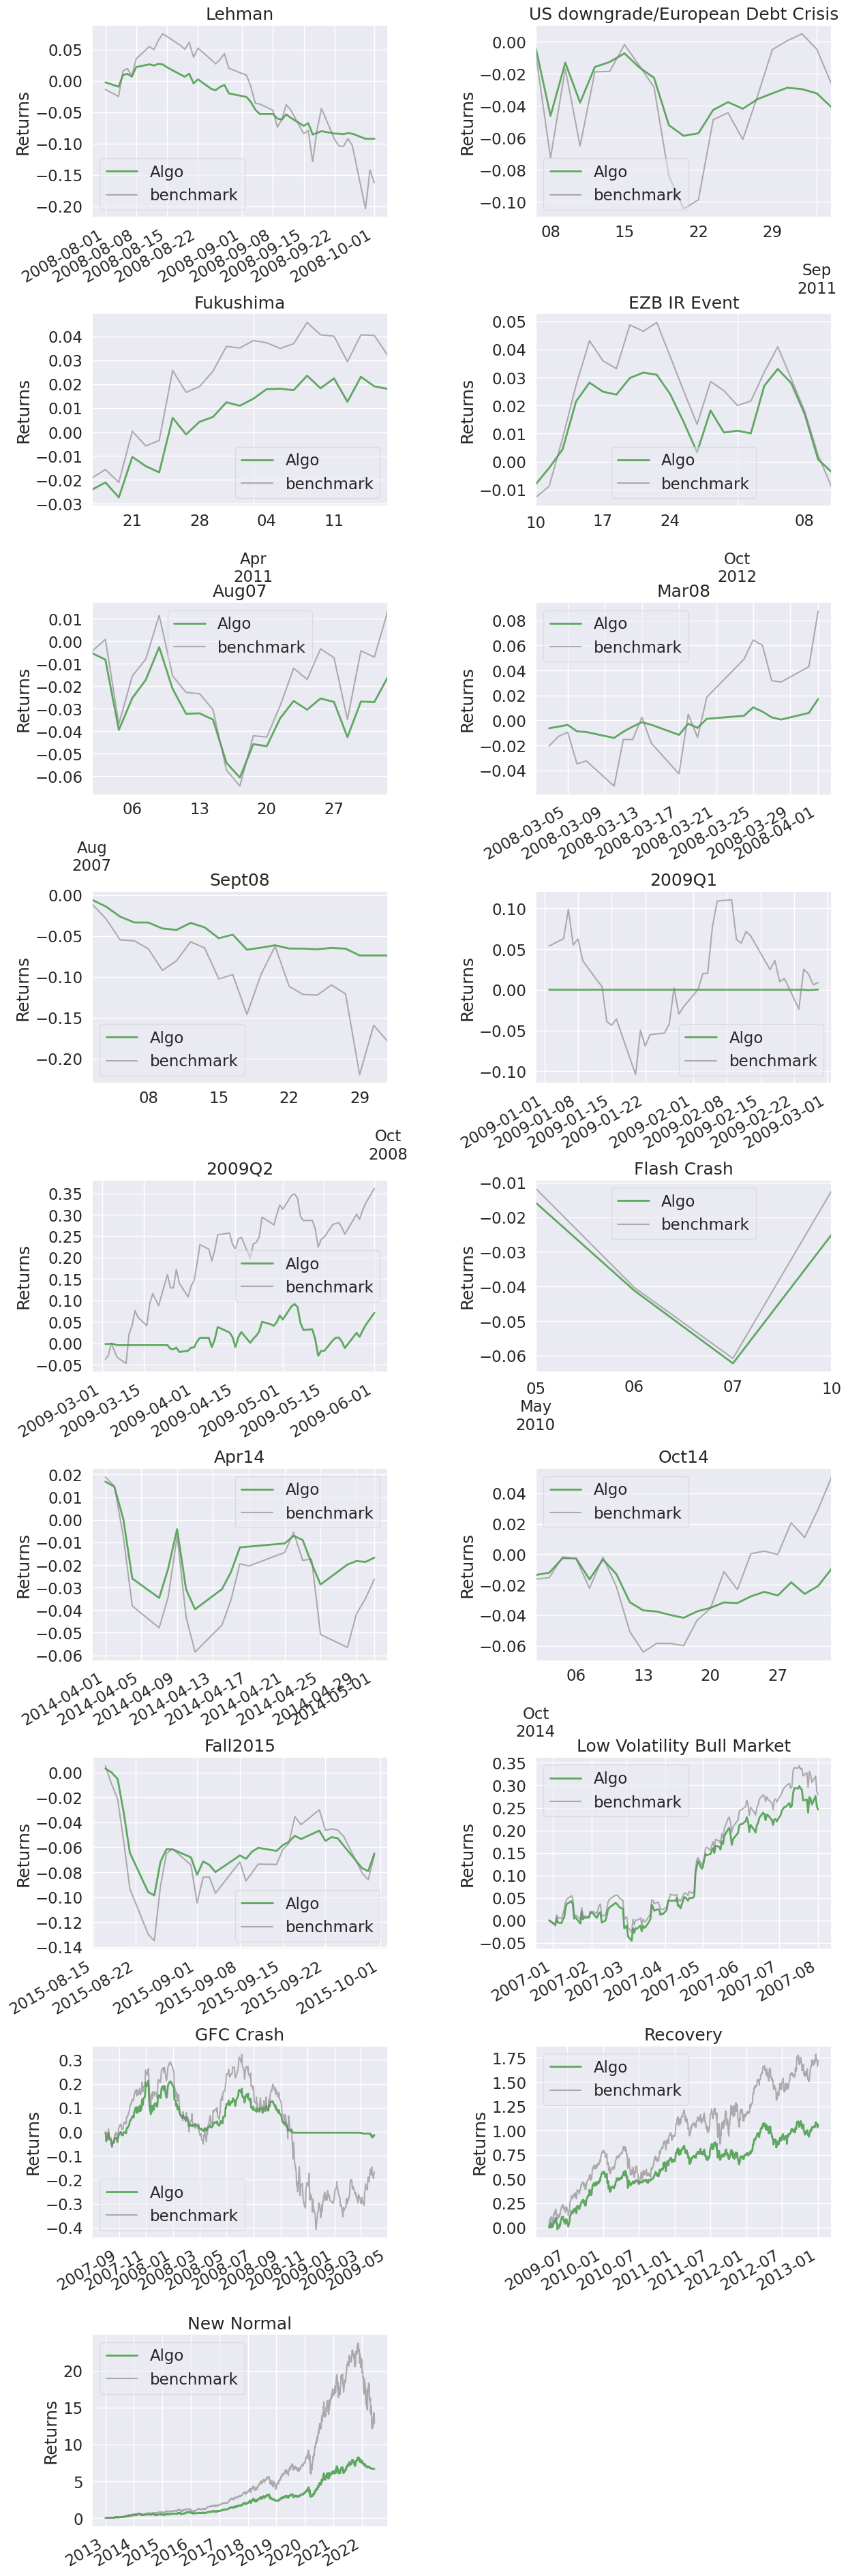

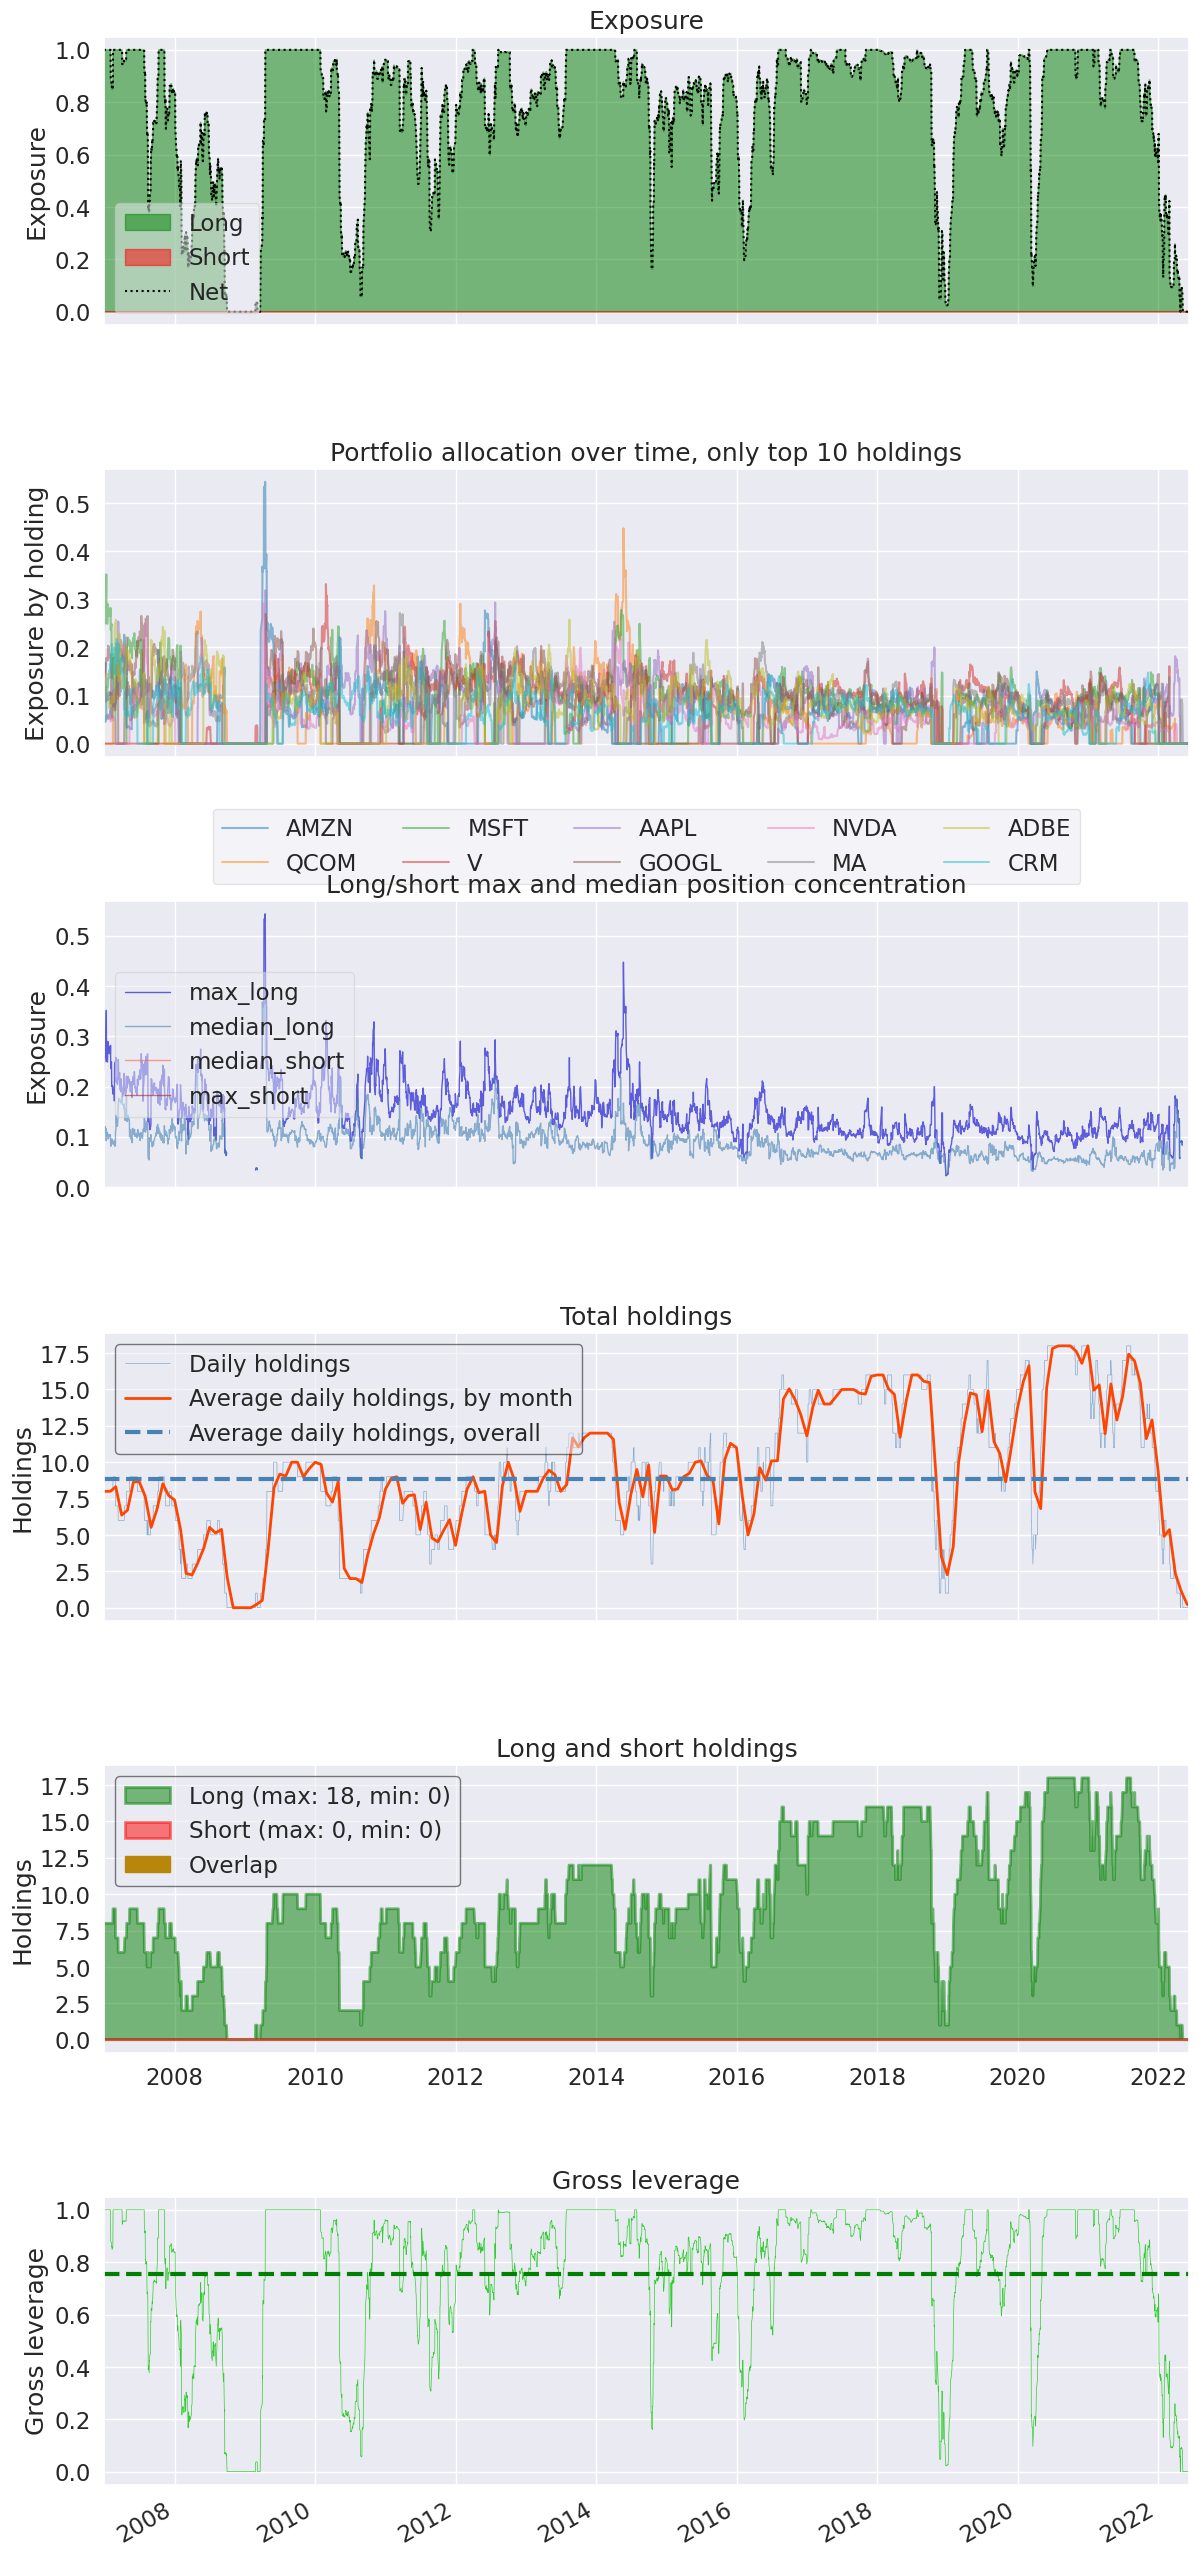

In [10]:
pos, cash, pv = positions_pv(adj_close_price, df.Rebalance, weights, cash_weight, start_date)
pos_ew, cash_ew, pv_ew = positions_pv_ew(adj_close_price, df.Rebalance, start_date)
strat_rets = pv / pv.shift(1) - 1
strat_rets_ew = pv_ew / pv_ew.shift(1) - 1
weights2 = weights.copy()
weights2['cash'] = cash_weight
# oos_date = pd.to_datetime('2018-01-01')
# type(oos_date)
# type(strat_rets.index)
# print(oos_date)
# print(strat_rets.index[300])
# print(oos_date > strat_rets.index[300])
pf.create_full_tear_sheet(strat_rets, positions = weights2, benchmark_rets = strat_rets_ew)
# pf.create_full_tear_sheet(strat_rets, positions = weights2, live_start_date=oos_date, benchmark_rets = strat_rets_ew)
# pf.create_returns_tear_sheet(strat_rets)